# qiskit.providers
核心功能：连接与抽象
它定义了抽象类（如 Backend），规定了像 run() 这样的标准方法。
任何公司或组织（如 IBM、AWS、IonQ）如果想让他们后端的量子设备或模拟器支持 Qiskit，就需要根据这些接口编写自己的 Provider。
对用户来说，无论后端是 IBM 的真机还是 AWS 的模拟器，都可以用一套统一的代码（circuit.run()）来提交任务，屏蔽了不同后端的具体实现细节。
核心对象：Backend（后端）
Provider 提供的主要是 Backend 对象。
一个 Backend 就代表一个可以执行量子电路（QuantumCircuit）的量子计算资源（硬件或软件模拟器）。
用户通过 backend.run(circuit) 来运行任务。

## Fake Provider
Qiskit 中的Fake Provider模块包含伪（模拟）后端类，可用于测试转译器和其他面向后端的功能

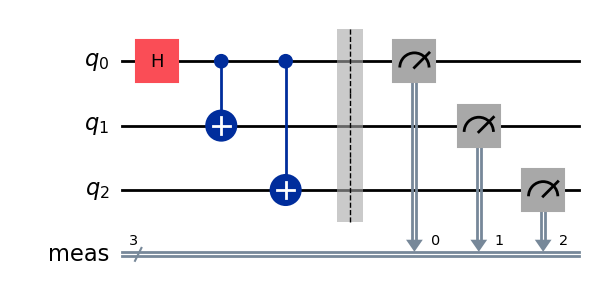

In [3]:
# 使用模拟后端进行转译和运行的示例
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
 
# Generate a 5-qubit simulated backend
backend = GenericBackendV2(num_qubits=5)
 
# Create a simple circuit
circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(0,2)
circuit.measure_all()
circuit.draw('mpl')


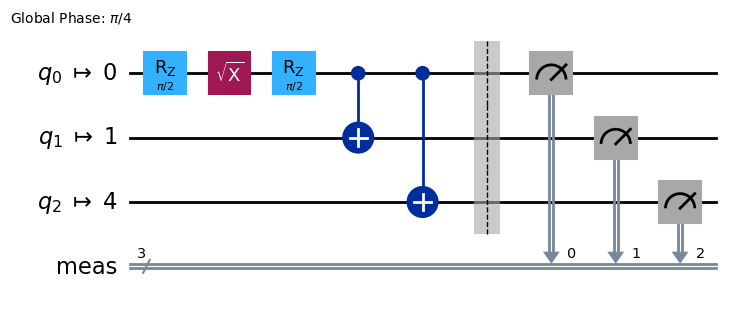

In [2]:
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(circuit, backend)
transpiled_circuit.draw('mpl')

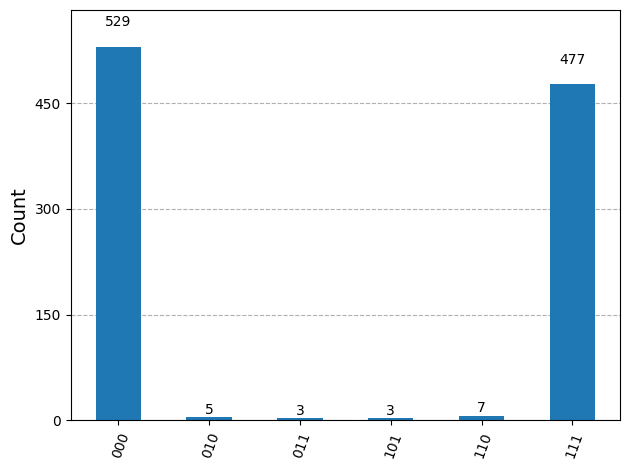

In [1]:

# Run the transpiled circuit using the simulated backend
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
plot_histogram(counts)

## GenericBackendV2
该类将返回一个 BackendV2 实例，该实例在本地模拟器上运行（秉承模拟后端的理念），并包含测试后端接口组件（例如转译器）所需的所有信息。GenericBackendV2 实例只需指定 num_qubits 即可构建，但用户可以额外配置基础门、耦合图、运行动态电路（控制流指令）的能力以及 dtm,随机生成属性：未指定的属性会从历史IBM后端数据范围中随机采样生成

参数：
num_qubits (int)  作用：后端的量子比特数量

basis_gates  作用：后端支持的基础门集合，默认值：["id", "rz", "sx", "x", "cx"]，特殊指令："reset", "delay", "measure" 总是默认支持，限制：必须是qiskit circuit library中的门

coupling_map (list[list[int]])
作用：定义量子比特之间的连接关系
格式：
边缘列表：[[0, 1], [0, 3], [1, 2]]
默认：如果不指定，生成完全连接图
要求：数量必须与 num_qubits 匹配

control_flow (bool)
作用：是否支持动态电路（控制流指令）
默认：False
支持指令：if_test, for_loop, while_loop, switch
示例：control_flow=True 启用动态电路支持

dtm (float | None)
作用：输出信号的系统时间分辨率（纳秒）

noise_info (bool)
作用：是否为门和量子比特关联默认噪声信息
默认：True

In [18]:
from qiskit.providers.fake_provider import GenericBackendV2

"""
backend_ex = GenericBackendV2(
    num_qubits=5,
    basis_gates=[""],
    control_flow=True,
    noise_info=True
)
"""
backend = GenericBackendV2(num_qubits=5)
# 方法说明：
# backend.set_options(shots=1024)  # 动态更新后端的运行时配置选项。
props = backend.qubit_properties(0)
print(props)  # 查询量子比特的信息
# 属性说明
# print(backend.coupling_map)  # 量子比特的连接
# print(backend.dt)
# print(backend.dtm)
# print(backend.operation_names)  # 后端支持的指令还有门操作
# print(backend.options)  # 用户可定制的后端如何运行的选项
# print(backend.provider)  # 返回NONE，GenericBackendV2 是一个独立创建的模拟后端，没有关联的 Provider，主要目的是本地测试，不需要真实的云服务提供商
# print(backend.version)
# print(backend.instruction_durations)  # 每个门或者其他等等操作的持续时间（通常以纳秒为单位）
# print(backend.instructions)  # 后端支持的所有指令列表
# print(backend.max_circuits)  # 返回 None 表示后端对并行电路数量没有硬性限制，实际能处理的电路数量取决于本地计算资源，硬件的实际并行处理能力上限
# print(backend.meas_map)  # 定义哪些量子比特可以同时进行测量的分组。

QubitProperties(t1=0.00011759326792826971, t2=0.00014800894948082245, frequency=5112477052.233961)


查询量子比特的信息阅读：
1. t1=0.000117593526792826971 - 能量弛豫时间
含义：量子比特从 |1⟩ 态衰减到 |0⟩ 态所需的时间
数值：约 117.59 微秒（0.00011759 秒）
意义：值越大越好，表示量子比特保持激发态的时间越长
对比：当前主流超导量子比特的 T1 通常在 50-200 微秒范围内，这个值算不错

2. t2=0.00014800894948982245 - 相位相干时间
含义：量子比特保持量子相干性的时间
数值：约 148.01 微秒（0.00014801 秒）
意义：值越大越好，表示量子叠加态能保持更久
重要提示：通常 T2 ≤ 2×T1，这里 T2 > T1，可能是测量误差或特殊设计

3. frequency=5112477052.2353961 - 共振频率
含义：该量子比特的能级跃迁频率
数值：约 5.112477052 GHz
意义：用于控制脉冲的频率调谐
典型范围：超导量子比特通常在 4-6 GHz 范围内

## BasicProvider: Python-based Simulators

In [19]:
from qiskit.providers.basic_provider import BasicProvider
 
backend = BasicProvider().get_backend('basic_simulator')  
print(backend.provider)  # 这个不是NONE，模拟真实的IBM等后端机器

BasicProvider
